# NOTEBOOK FOR DEFENSE TECHNQUES

In [1]:
%run Chinese_MNIST_preprocessing.ipynb


Skipping, found downloaded files in ".\chinese-mnist" (use force=True to force download)


In [2]:
# import of libraries
# file management libraries
import os
import pickle
import random

#libraries for data preprocessing
import numpy as np

#libraries for data visualization
import matplotlib.pyplot as plt


#libraries for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import TensorDataset, DataLoader




In [129]:
def set_seed(seed):
    """
    Sets the seed for random number generators to ensure reproducibility.
    
    Parameters:
    seed (int): The seed value to be used.
    """
    torch.manual_seed(seed)  # Set the seed for PyTorch
    torch.cuda.manual_seed(seed)  # Set the seed for CUDA (GPU)
    torch.cuda.manual_seed_all(seed)  # Set the seed for all GPUs if using multiple GPUs
    np.random.seed(seed)  # Set the seed for NumPy (used for random number generation outside PyTorch)
    random.seed(seed)  # Set the seed for Python's random module
    torch.backends.cudnn.deterministic = True  # Makes some GPU operations deterministic
    torch.backends.cudnn.benchmark = False  # Disables dynamic CUDNN optimization (may impact performance)

# Example of usage
set_seed(42)  # You can use any integer as a seed

# Prepating data format

It is very import when we use pytorch to well format the data (tensor, dataloader,...)

In [4]:
def prepare_set_data(set_set):
    """
    Prepare the image tensors and labels from a given dataset.

    Parameters:
    set_set (list): The dataset containing images and labels.

    Returns:
    set_img_tensors (torch.Tensor): The image tensors of the dataset.
    set_labels (torch.Tensor): The labels of the dataset.
    """
    set_images = []
    set_labels = []

    # Separate the labels and images from the dataset
    for i in range(len(set_set)):
        set_images.append(set_set[i][0])
        set_labels.append(int(set_set[i][1][-2:]) - 1)  # Subtract 1 here (so 0 corresponds to 01, 1 to 02, etc.) because the loss function expects 0-starting labels

    set_img_tensors = torch.tensor(set_images, dtype=torch.float32).permute(0, 3, 1, 2)
    set_labels = torch.tensor(set_labels, dtype=torch.long)

    return set_img_tensors, set_labels


C:\Users\choho\AppData\Local\Temp\ipykernel_16056\1652656436.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  set_img_tensors = torch.tensor(set_images, dtype=torch.float32).permute(0, 3, 1, 2)


In [ ]:
# Load the training and testing datasets in tensors format (images and labels) 
test_img_tensors, test_labels = prepare_set_data(test_set)
train_img_tensors, train_labels = prepare_set_data(train_set)

In [5]:
# Put into dataloader because we will use mini-batch gradient descent

# TRAINING SET
train_dataset = TensorDataset(train_img_tensors, train_labels)
train_loader = DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)

# TEST SET
test_dataset = TensorDataset(test_img_tensors, test_labels)
test_loader = DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

# 1. BASELINE CNN Model for Chiness-Mnist

We define a CNN using built-in function of Pytorch for computation efficiency (Use of GPU, TPU) instead of using numpy from scratch which will have cause us take a
long time for computation (even with library like numba for accelerating numpy)

### 1.1 Define the CNN model using a python Class 

In [175]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=15):
        super(CNNModel, self).__init__()

        # Define the convolutional layers
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Calculate the input size of the first linear layer based on the output of the convolutional layers
        self.fc1_input_size = 32 * 16 * 16  # 32 channels, 16x16 size after max-pooling

        # Define the fully connected layers
        self.classifier = nn.Sequential(
            nn.Linear(self.fc1_input_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.reshape(x.size(0), -1) 
        x = self.classifier(x)
        return x

# Create an instance of the model
model = CNNModel(num_classes=15)

# Print the model
print(model)


CNNModel(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=8192, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=15, bias=True)
  )
)


In [ ]:
# Create an instance of the model
model = CNNModel(num_classes=15)

# Print the model
print(model)

### 1.2 Training the CNN model

In [171]:
# Fonction d'entraînement
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for batch in dataloader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    return {'output': outputs,  # Pour afficher les prédictions sur le dernier lot
        'train_loss': total_loss / len(dataloader),
        'train_acc': total_correct / total_samples,
    }

# Fonction de validation
def validate_one_epoch(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            
    return {'output': outputs,  # Pour afficher les prédictions sur le dernier lot
        'val_loss': total_loss / len(dataloader),
        'val_acc': total_correct / total_samples,
    }



In [ ]:
# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Entraînement et évaluation du modèle sur plusieurs époques
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 50
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # Define the optimizer


# Entraînement et évaluation du modèle sur plusieurs époques
for epoch in range(num_epochs):
    train_result = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
    val_result = validate_one_epoch(model, test_loader, loss_fn, device)

    # Affichage des résultats pour chaque époque
    print(f'Époque {epoch+1}/{num_epochs}')
    print(f'Entraînement - Perte: {train_result["train_loss"]:.4f}, Accuracy: {train_result["train_acc"]:.4f}')
    print(f'Validation - Perte: {val_result["val_loss"]:.4f}, Accuracy: {val_result["val_acc"]:.4f}')


# sauvegarder le modèle
torch.save(model.state_dict(), 'baseline_model.pth')

# charger le modèle
model = CNNModel(num_classes=15)
model.load_state_dict(torch.load('baseline_model.pth'))
model.eval()


In [156]:
# load the modèle
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNModel(num_classes=15)
model.load_state_dict(torch.load('baseline_model.pth'))
model.eval()


CNNModel(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=8192, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=15, bias=True)
  )
)

In [10]:
def get_all_predictions(model, dataloader, device):
    """ function to get all predictions of a model on a dataset 
    parameters: 
    model: the model to use for prediction
    dataloader: the dataset to predict
    device: the device to use for prediction
    returns:
    all_predictions: the predictions of the model on the dataset
    """
    
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_predictions, all_labels


In [176]:
# Use the function to obtain predictions on the test data set
test_predictions, test_labels = get_all_predictions(model, test_loader, device)

# Use the function to obtain predictions on the test data set
print("Prédictions:", test_predictions)
print("Étiquettes réelles:", test_labels)

Prédictions: [2, 12, 12, 8, 12, 7, 12, 12, 7, 11, 8, 8, 8, 8, 8, 12, 7, 9, 7, 8, 7, 12, 12, 11, 7, 12, 7, 7, 12, 8, 7, 12, 8, 12, 13, 9, 7, 7, 7, 9, 9, 7, 12, 3, 12, 12, 8, 7, 7, 7, 12, 3, 8, 8, 7, 8, 7, 12, 12, 12, 12, 12, 7, 8, 12, 7, 12, 12, 12, 9, 12, 12, 12, 7, 12, 4, 9, 6, 7, 8, 12, 8, 7, 9, 7, 8, 9, 7, 7, 9, 7, 7, 11, 8, 8, 11, 7, 12, 7, 7, 12, 8, 9, 12, 9, 12, 12, 7, 12, 7, 7, 12, 7, 9, 7, 7, 7, 12, 10, 8, 7, 7, 11, 12, 12, 1, 12, 7, 1, 3, 12, 12, 12, 9, 12, 7, 9, 7, 8, 12, 8, 12, 2, 7, 12, 7, 7, 12, 8, 8, 12, 7, 3, 7, 12, 12, 8, 9, 9, 12, 12, 8, 7, 9, 7, 9, 7, 12, 7, 2, 12, 1, 12, 12, 12, 7, 7, 9, 8, 8, 8, 12, 7, 9, 12, 7, 7, 8, 12, 8, 12, 12, 7, 8, 12, 1, 7, 7, 12, 12, 2, 8, 8, 8, 9, 12, 12, 8, 12, 7, 12, 7, 7, 9, 8, 8, 7, 12, 9, 7, 12, 12, 12, 12, 12, 9, 7, 12, 12, 12, 3, 7, 12, 7, 12, 6, 7, 7, 8, 9, 9, 12, 7, 7, 2, 8, 7, 9, 12, 9, 2, 6, 7, 7, 12, 12, 12, 7, 12, 12, 7, 12, 7, 3, 7, 8, 9, 12, 8, 7, 7, 7, 8, 7, 8, 12, 7, 7, 7, 12, 8, 12, 7, 8, 12, 7, 9, 8, 8, 12, 9, 7, 12, 12,

# 2. ATTAQUE METHODS apply to dataset

# 2.1 Fast Sign Gradient Methods

In [177]:
# Définition de la fonction FGSM
def FGSM(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image


Test accuracy on adversarial images: 0.04800000041723251


In [ ]:
# Paramètre de l'attaque
epsilon = 0.01

# Charger les données de test
test_img_tensors, test_labels = prepare_set_data(test_set)
test_img_tensors.requires_grad = True

# Passer les images dans le modèle et calculer les pertes
outputs = model(test_img_tensors.to(device))
loss = F.cross_entropy(outputs, test_labels.to(device))

# Remettre à zéro les gradients existants dans le modèle et effectuer la rétropropagation
model.zero_grad()
loss.backward()

# Collecter les gradients par rapport aux images d'entrée
data_grad = test_img_tensors.grad.data

# Appliquer FGSM sur les images de test
perturbed_data_test = FGSM(test_img_tensors, epsilon, data_grad)

# Évaluer le modèle sur les images adverses
output = model(perturbed_data_test.to(device))
final_loss = F.cross_entropy(output, test_labels.to(device))
final_acc = (output.max(1)[1] == test_labels.to(device)).float().mean()
print('\nTest accuracy on adversarial images:', final_acc.item())

In [13]:
# Charger les données d'entraînement
train_img_tensors, train_labels = prepare_set_data(train_set)
train_img_tensors.requires_grad = True

# Passer les images d'entraînement dans le modèle et calculer les pertes
outputs_train = model(train_img_tensors.to(device))
loss_train = F.cross_entropy(outputs_train, train_labels.to(device))

# Remettre à zéro les gradients existants dans le modèle et effectuer la rétropropagation pour les images d'entraînement
model.zero_grad()
loss_train.backward()

# Collecter les gradients par rapport aux images d'entraînement
data_grad_train = train_img_tensors.grad.data

# Appliquer FGSM sur les images d'entraînement
perturbed_data_train = FGSM(train_img_tensors, epsilon, data_grad_train)

# Évaluer le modèle sur les images adverses d'entraînement
output_train = model(perturbed_data_train.to(device))
final_loss_train = F.cross_entropy(output_train, train_labels.to(device))
final_acc_train = (output_train.max(1)[1] == train_labels.to(device)).float().mean()
print('\nTraining accuracy on adversarial images:', final_acc_train.item())



Training accuracy on adversarial images: 0.6489999890327454


In [180]:
def evaluate_model_on_adversarial_examples(model, pertub, data_set, epsilon, device):
    """
    Evaluates the model on adversarial examples generated using the FGSM attack.

    Parameters:
    model (torch.nn.Module): The neural network model to evaluate.
    data_set (tuple): A tuple containing the input tensors and labels.
    epsilon (float): The epsilon value for the pertubation attack to create adversarial examples.
    device (torch.device): The device to perform computation on.

    Returns:
    float: The accuracy of the model on adversarial examples.
    float: The loss of the model on adversarial examples.
    """

    # Prepare the data
    img_tensors, labels = prepare_set_data(data_set)
    img_tensors.requires_grad = True

    # Pass the images through the model and calculate the loss
    outputs = model(img_tensors.to(device))
    loss = F.cross_entropy(outputs, labels.to(device))

    # Zero existing gradients in the model and perform backpropagation
    model.zero_grad()
    loss.backward()

    # Collect the gradients with respect to the input images
    data_grad = img_tensors.grad.data

    # Apply pertubation to the images to create adversarial examples
    perturbed_data = pertub(img_tensors, epsilon, data_grad)

    # Evaluate the model on the adversarial examples
    output = model(perturbed_data.to(device))
    final_loss = F.cross_entropy(output, labels.to(device))
    final_acc = (output.max(1)[1] == labels.to(device)).float().mean()

    return final_acc.item(), final_loss.item()



In [181]:
# Usage example
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epsilon = 0.01

# Evaluate on train data
train_accuracy, train_loss = evaluate_model_on_adversarial_examples(model, FGSM, train_set, epsilon, device)
print('\nTraining accuracy on adversarial images:', train_accuracy)
print('Training loss on adversarial images:', train_loss)


# Evaluate on test data
test_accuracy, test_loss = evaluate_model_on_adversarial_examples(model,FGSM, test_set, epsilon, device)
print('\nTest accuracy on adversarial images:', test_accuracy)
print('Test loss on adversarial images:', test_loss)





Test accuracy on adversarial images: 0.04800000041723251
Test loss on adversarial images: 2.7114899158477783


# 2.2 Projected_gradient_descent 

In [182]:
def pgd_attack(model, img, labels, eps, alpha, num_iter):
    # Copie l'image et assure que les gradients peuvent être calculés
    img_disturbed = img.clone().detach().requires_grad_(True)

    for _ in range(num_iter):
        # Réinitialise les gradients
        if img_disturbed.grad is not None:
            img_disturbed.grad.data.zero_()

        # Calcule la perte
        predictions = model(img_disturbed)
        loss = F.cross_entropy(predictions, labels)

        # Calcule les gradients
        loss.backward()

        # Applique l'attaque PGD
        with torch.no_grad():
            img_disturbed.data += alpha * img_disturbed.grad.data.sign()
            img_disturbed.data = torch.clamp(img_disturbed.data, min=img.data - eps, max=img.data + eps)
            img_disturbed.data = torch.clamp(img_disturbed.data, min=0, max=1)

    return img_disturbed


In [ ]:
# Charger les données d'entraînement
train_img_tensors, train_labels = prepare_set_data(train_set)
train_img_tensors.requires_grad = True

# Passer les images d'entraînement dans le modèle et calculer les pertes
outputs_train = model(train_img_tensors.to(device))
loss_train = F.cross_entropy(outputs_train, train_labels.to(device))

# Remettre à zéro les gradients existants dans le modèle et effectuer la rétropropagation pour les images d'entraînement
model.zero_grad()
loss_train.backward()

# Collecter les gradients par rapport aux images d'entraînement
data_grad_train = train_img_tensors.grad.data

# Appliquer FGSM sur les images d'entraînement
epsilon = 0.1  
alpha = 0.01 
num_iter = 2 
pgd_attack(model, train_img_tensors, train_labels, epsilon, alpha, num_iter)

# Évaluer le modèle sur les images adverses d'entraînement
output_train = model(perturbed_data_train.to(device))
final_loss_train = F.cross_entropy(output_train, train_labels.to(device))
final_acc_train = (output_train.max(1)[1] == train_labels.to(device)).float().mean()
print('\nTraining accuracy on adversarial images:', final_acc_train.item())


# 2.3 Carlini&Wagner


# 3. Visualisation of the attacks

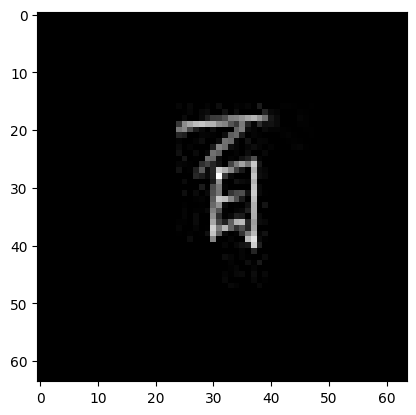

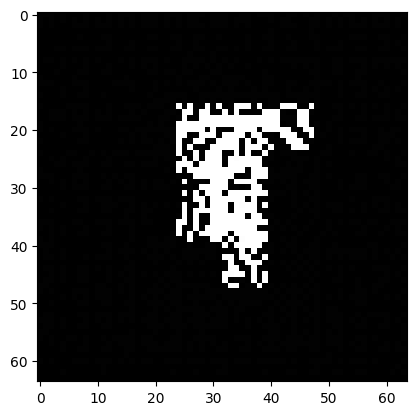

In [14]:
#affiche une image avant et après pertubation
import matplotlib.pyplot as plt
import numpy as np

# Définition de la fonction pour afficher une image
def imshow(img):
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

# Définition de la fonction pour afficher une image avant et après perturbation
def show_images(image, perturbed_image):
    img = image[0]
    perturbed_img = perturbed_image[0]
    imshow(img.cpu())
    imshow(perturbed_img.cpu())

# Afficher une image avant et après perturbation
show_images(test_img_tensors, perturbed_data_test)


# II. Apply defence Techniques

- II - 1 . Implementation 1 of Adversariables Training (Goodfellow et al.(2015)) 
- II - 2 . Implementation 2 of Adversariables Training (Goodfellow et al.(2015)
- II - 3 . Implemtation of Defensive GAN (Samangouei et al. (2018))


## adversarial training by step by step optimization : adverse --> originale -->adverse --> ...

In [15]:
def adversarial_training(model, train_loader, epsilon, optimizer, loss_fn, device, num_epochs):
    for epoch in range(num_epochs):
        for batch in train_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            # Création d'exemples adverses avec FGSM
            images.requires_grad = True
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            model.zero_grad()
            loss.backward()
            data_grad = images.grad.data
            perturbed_images = FGSM(images, epsilon, data_grad)

            # Entraînement avec les données originales
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            # Entraînement avec les données adverses
            optimizer.zero_grad()
            outputs_adv = model(perturbed_images)
            loss_adv = loss_fn(outputs_adv, labels)
            loss_adv.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{num_epochs} completed.")
    return model

# Paramètres
epsilon = 0.1  # Paramètre pour FGSM
num_epochs = 5  # Nombre d'époques pour l'entraînement
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Entraînement adversarial
model_robust_1 = adversarial_training(model, train_loader, epsilon, optimizer, loss_fn, device, num_epochs)

#sauvegarder le modèle
torch.save(model_robust_1.state_dict(), 'model_robust_1.pth')




Epoch 1/5 completed.
Epoch 2/5 completed.
Epoch 3/5 completed.
Epoch 4/5 completed.
Epoch 5/5 completed.


In [16]:
# charger le modèle
model_robust_1 = CNNModel(num_classes=15)
model_robust_1.load_state_dict(torch.load('model_robust_1.pth'))
model_robust_1.eval()

# Évaluer le modèle robuste sur les images adverses
output = model_robust_1(perturbed_data_test.to(device))
final_loss = F.cross_entropy(output, test_labels.to(device))
final_acc = (output.max(1)[1] == test_labels.to(device)).float().mean()
print('\nTest accuracy on adversarial images:', final_acc.item())



Test accuracy on adversarial images: 0.7693333625793457


In [17]:
# charger le modèle
#model_robust_1 = CNNModel(num_classes=15)
#model_robust_1.load_state_dict(torch.load('model_robust_1.pth'))
#model_robust_1.eval()

# Évaluer le modèle robuste sur les images adverses
output = model_robust_1(perturbed_data_train.to(device))
final_loss = F.cross_entropy(output, train_labels.to(device))
final_acc = (output.max(1)[1] == train_labels.to(device)).float().mean()
print('\nTrain accuracy on adversarial images:', final_acc.item())



Train accuracy on adversarial images: 0.7925000190734863


# adversial training by weighting losss (  Goodfellow et al.(2015)

$$

\theta^* = arg\min_{\theta}  \lambda  J(\theta, x, y) + (1-\lambda)  J(\theta, x', y) 

$$

In [18]:
def adversarial_loss(model, clean_data, adversary_data, labels, alpha, loss_fn, device):
    # Calcul de la perte sur les exemples propres
    clean_outputs = model(clean_data)
    clean_loss = loss_fn(clean_outputs, labels)

    # Calcul de la perte sur les exemples adverses
    adversary_outputs = model(adversary_data)
    adversary_loss = loss_fn(adversary_outputs, labels)

    # Combinaison des deux pertes
    combined_loss = alpha * clean_loss + (1 - alpha) * adversary_loss
    return combined_loss


In [19]:
# Définition de la fonction pour évaluer la performance sur perturbed_data_test
def validate_perturbed(model, perturbed_data_test, test_labels, device):
    model.eval()
    total_correct = 0
    total_samples = perturbed_data_test.shape[0]
    
    with torch.no_grad():
        # Assurez-vous que perturbed_data_test est sur le bon appareil
        perturbed_data_test = perturbed_data_test.to(device)
        test_labels = test_labels.to(device)
        
        # Passez les images perturbées dans le modèle
        outputs = model(perturbed_data_test)
        _, predicted = torch.max(outputs, 1)
        total_correct = (predicted == test_labels).sum().item()
    
    accuracy = total_correct / total_samples
    return accuracy


In [18]:
def validate_model(model, dataloader, device):
    model.eval()
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
    
    accuracy = total_correct / total_samples
    return accuracy

# List of different lambda values to test
lambda_values = np.linspace(0, 1, num=5)  # for example: 0, 0.25, 0.5, 0.75, 1

# Dictionary to save accuracy for each lambda value
lambda_accuracies = {}
num_epochs = 2
for lambda_value in lambda_values:
    # Reset the model and optimizer
    model = CNNModel(num_classes=15)
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    
    # Train the model with the current lambda value
    for epoch in range(num_epochs):
        for batch in train_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            
            # Create adversarial examples with FGSM
            images.requires_grad = True
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            model.zero_grad()
            loss.backward()
            images_grad = images.grad.data
            perturbed_images = FGSM(images, epsilon, images_grad)
            
            # Calculate mixed loss and update weights
            model.zero_grad()
            loss = adversarial_loss(model, images, perturbed_images, labels, lambda_value, F.cross_entropy, device)
            loss.backward()
            optimizer.step()
            
        print(f"Epoch {epoch+1}/{num_epochs} completed for lambda={lambda_value:.2f}.")

    # Evaluate the model and save accuracy
    accuracy = validate_model(model, test_loader, device)
    perturbed_accuracy = validate_perturbed(model, perturbed_data_test, test_labels, device)

    lambda_accuracies[lambda_value] = (accuracy, perturbed_accuracy)
    print(f"Validation accuracy for lambda={lambda_value:.2f}: {accuracy:.4f}")
    print(f'Accuracy on perturbed test data: {perturbed_accuracy:.4f}')


Epoch 1/2 completed for lambda=0.00.
Epoch 2/2 completed for lambda=0.00.
Validation accuracy for lambda=0.00: 0.2097
Accuracy on perturbed test data: 0.1933
Epoch 1/2 completed for lambda=0.25.
Epoch 2/2 completed for lambda=0.25.
Validation accuracy for lambda=0.25: 0.8417
Accuracy on perturbed test data: 0.4267
Epoch 1/2 completed for lambda=0.50.
Epoch 2/2 completed for lambda=0.50.
Validation accuracy for lambda=0.50: 0.8410
Accuracy on perturbed test data: 0.3323
Epoch 1/2 completed for lambda=0.75.
Epoch 2/2 completed for lambda=0.75.
Validation accuracy for lambda=0.75: 0.8770
Accuracy on perturbed test data: 0.2053
Epoch 1/2 completed for lambda=1.00.
Epoch 2/2 completed for lambda=1.00.
Validation accuracy for lambda=1.00: 0.8280
Accuracy on perturbed test data: 0.1217


TypeError: unsupported format string passed to tuple.__format__

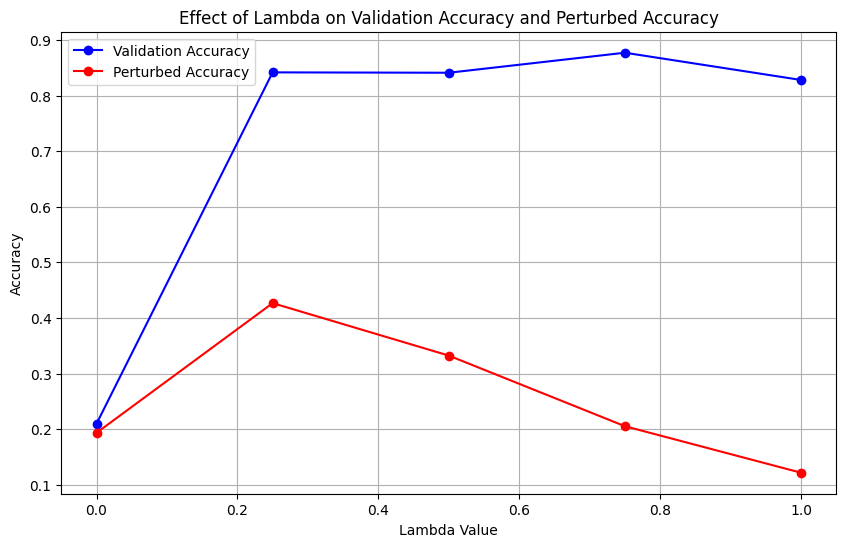

In [19]:
# Data simulation for the example
lambda_values = list(lambda_accuracies.keys())  # Simulated lambda values, ranging from 0.0 to 1.0
accuracy_values = [accuracy[0] for accuracy in lambda_accuracies.values()]  # Simulated accuracy for each lambda value
perturbed_accuracy_values = [accuracy[1] for accuracy in lambda_accuracies.values()]  # Simulated perturbed accuracy for each lambda value

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(lambda_values, accuracy_values, marker='o', linestyle='-', color='blue', label='Validation Accuracy')
plt.plot(lambda_values, perturbed_accuracy_values, marker='o', linestyle='-', color='red', label='Perturbed Accuracy')

# Titles and labels
plt.title('Effect of Lambda on Validation Accuracy and Perturbed Accuracy')
plt.xlabel('Lambda Value')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


# Defense - GAN

--- Code from the graded TP from course Deep Learning II : Master data science followed by one member of our group -----

-- **the main part (which was graded)** is completed by the student even if the structure of the code come from the teacher

-- what we bring ourselves: 
        --> we correct the TP 
        --> we put it in Pytorch instead of keras to be coherent in all our codes
        --> we use the **weistrass-distance** like it is in the paper above instead of using KullbackLeibler Divergence distance used in the TP (and in standard GAN) 


-- **We improve the code so that, it correspond to the Defence-GAN (WGAN) introduced by the paper **DEFENSE-GAN: PROTECTING CLASSIFIERS AGAINST ADVERSARIAL ATTACKS USING
GENERATIVE MODELS Pouya Samangouei∗, Maya Kabkab∗ , and Rama Chellappa (2018)**

# 1. STANDARD GAN

In [20]:

# Define the Generator network
class Generator(nn.Module):
    def __init__(self, z_dim, img_shape):
        super(Generator, self).__init__()
        self.img_shape = img_shape
        self.model = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img

# Define the Discriminator network
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        flattened = img.view(img.size(0), -1)
        validity = self.model(flattened)
        return validity

class GAN():
    def __init__(self, dataset_name='mnist'):
        # Load data
        self.img_shape = (1, 64, 64)  # for MNIST
        self.z_dim = 100
        self.dataset_name = dataset_name
        self.model_file = f'models/{self.dataset_name}_gan_model.pickle'

        # Define networks
        self.generator = Generator(self.z_dim, self.img_shape)
        self.discriminator = Discriminator(self.img_shape)

        # Optimizers
        self.optimizer_G = optim.Adam(self.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.optimizer_D = optim.Adam(self.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

        # Loss function
        self.adversarial_loss = nn.BCELoss()

    def load_gan_data(self):
        # MNIST Dataset
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

        dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
        return dataloader

    def train(self, epochs, train_loader, sample_interval=1000):
        for epoch in range(epochs):
            for i, (imgs, _) in enumerate(train_loader):
                # Adversarial ground truths
                valid = Variable(torch.FloatTensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
                fake = Variable(torch.FloatTensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

                # Configure input
                real_imgs = Variable(imgs.type(torch.FloatTensor))

                # -----------------
                #  Train Generator
                # -----------------
                self.optimizer_G.zero_grad()

                # Sample noise as generator input
                z = Variable(torch.FloatTensor(np.random.normal(0, 1, (imgs.size(0), self.z_dim))))

                # Generate a batch of images
                gen_imgs = self.generator(z)

                # Loss measures generator's ability to fool the discriminator
                g_loss = self.adversarial_loss(self.discriminator(gen_imgs), valid)

                g_loss.backward()
                self.optimizer_G.step()

                # ---------------------
                #  Train Discriminator
                # ---------------------
                self.optimizer_D.zero_grad()

                # Measure discriminator's ability to classify real from generated samples
                real_loss = self.adversarial_loss(self.discriminator(real_imgs), valid)
                fake_loss = self.adversarial_loss(self.discriminator(gen_imgs.detach()), fake)
                d_loss = (real_loss + fake_loss) / 2

                d_loss.backward()
                self.optimizer_D.step()

                print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(train_loader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

                # If at save interval => save generated image samples and model checkpoints
                if i % sample_interval == 0:
                    # Save image samples
                    # Save model checkpoints                    
                    self.save_sample_images(epoch, i)
                    torch.save(self.generator.state_dict(), f'results/generator_epoch{epoch}_batch{i}.pth')
                    torch.save(self.discriminator.state_dict(), f'results/discriminator_epoch{epoch}_batch{i}.pth')                
                
    def save_sample_images(self, epoch, batch):
        # Generate noise
        z = Variable(torch.FloatTensor(np.random.normal(0, 1, (25, self.z_dim))))

        # Generate images from noise
        gen_imgs = self.generator(z).detach()

        # Rescale images from [-1, 1] to [0, 1] range
        gen_imgs = (gen_imgs + 1) / 2

        # Save image grid
        save_image(gen_imgs.data, f'results/epoch{epoch}_batch{batch}.png', nrow=5, normalize=True)


In [37]:
# Assume test_data is already defined and processed by your prepared_data function
# from standard_GAN import GAN

gan = GAN()
gan.train(epochs=1, train_loader=train_dataset)


[Epoch 0/1] [Batch 0/12000] [D loss: 0.4420568645000458] [G loss: 0.6891074776649475]
[Epoch 0/1] [Batch 1/12000] [D loss: 0.37872880697250366] [G loss: 0.7029939889907837]
[Epoch 0/1] [Batch 2/12000] [D loss: 0.334249347448349] [G loss: 0.7314469814300537]
[Epoch 0/1] [Batch 3/12000] [D loss: 0.32692721486091614] [G loss: 0.7530546188354492]
[Epoch 0/1] [Batch 4/12000] [D loss: 0.3925017714500427] [G loss: 0.7634291648864746]
[Epoch 0/1] [Batch 5/12000] [D loss: 0.3152598738670349] [G loss: 0.7615586519241333]
[Epoch 0/1] [Batch 6/12000] [D loss: 0.3101949095726013] [G loss: 0.7716238498687744]
[Epoch 0/1] [Batch 7/12000] [D loss: 0.30087992548942566] [G loss: 0.793734073638916]
[Epoch 0/1] [Batch 8/12000] [D loss: 0.3062424063682556] [G loss: 0.7810301184654236]
[Epoch 0/1] [Batch 9/12000] [D loss: 0.3081147372722626] [G loss: 0.7765039801597595]
[Epoch 0/1] [Batch 10/12000] [D loss: 0.30130326747894287] [G loss: 0.7927089929580688]
[Epoch 0/1] [Batch 11/12000] [D loss: 0.30866876244

In [21]:
# Assume test_data is already defined and processed by your prepared_data function
gan_2 = GAN()
gan_2.train(epochs=1, train_loader=test_dataset, sample_interval=1000)


[Epoch 0/1] [Batch 0/3000] [D loss: 1.039398431777954] [G loss: 0.6991767883300781]
[Epoch 0/1] [Batch 1/3000] [D loss: 0.384276807308197] [G loss: 0.726201593875885]
[Epoch 0/1] [Batch 2/3000] [D loss: 0.3274431824684143] [G loss: 0.7491491436958313]
[Epoch 0/1] [Batch 3/3000] [D loss: 0.31966477632522583] [G loss: 0.7575810551643372]
[Epoch 0/1] [Batch 4/3000] [D loss: 0.30848070979118347] [G loss: 0.7758639454841614]
[Epoch 0/1] [Batch 5/3000] [D loss: 0.3063189685344696] [G loss: 0.7887127995491028]
[Epoch 0/1] [Batch 6/3000] [D loss: 0.2966379225254059] [G loss: 0.8041120171546936]
[Epoch 0/1] [Batch 7/3000] [D loss: 0.30804190039634705] [G loss: 0.7919904589653015]
[Epoch 0/1] [Batch 8/3000] [D loss: 0.29663434624671936] [G loss: 0.8041196465492249]
[Epoch 0/1] [Batch 9/3000] [D loss: 0.296902596950531] [G loss: 0.803653359413147]
[Epoch 0/1] [Batch 10/3000] [D loss: 0.33255425095558167] [G loss: 0.8138642907142639]
[Epoch 0/1] [Batch 11/3000] [D loss: 0.3416380286216736] [G loss

# 2. DEFENCE GAN


![utils/algo_defence_GAN.png](algo_defence_GAN.png)


In [132]:
# Function to optimize the latent vector
def optimize_latent_vector(generator, input_img, latent_dim, device, steps=20, lr=0.01):
    """
    Optimizes the latent vector 'z' of the generator to reconstruct the input image.
    
    Parameters:
    generator (torch.nn.Module): The generator model that takes a latent vector 'z'.
    input_img (torch.Tensor): The image to be reconstructed by the generator.
    latent_dim (int): The dimensionality of the latent space.
    device (torch.device): The device (CPU/GPU) on which the computation will be performed.
    steps (int): The number of optimization steps.
    lr (float): The learning rate for the optimizer.
    
    Returns:
    torch.Tensor: The optimized latent vector 'z'.
    """
    set_seed(42) 
    # Move the input image to the specified device
    input_img = input_img.to(device)
    
    # Initialize the latent vector with random noise and enable gradient computation
    z = Variable(torch.randn(1, latent_dim).to(device), requires_grad=True)
    
    # Set up the optimizer for the latent vector
    optimizer = torch.optim.Adam([z], lr=lr)

    # Optimization loop
    for step in range(steps):
        optimizer.zero_grad()  # Clear previous gradients
        reconstructed_img = generator(z).squeeze(1)  # Generate the reconstructed image
        loss = F.mse_loss(reconstructed_img, input_img)  # Compute the MSE loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Update the latent vector 'z'

    return z.detach()  # Detach 'z' from the computation graph and return

# Function to reconstruct the image and classify
def defense_gan_classifier(generator, classifier, input_img, latent_dim, device):
    """
    Uses DefenseGAN approach to reconstruct the image using the generator and then classifies it using the classifier.
    
    Parameters:
    generator (torch.nn.Module): The generator model for image reconstruction.
    classifier (torch.nn.Module): The classifier model for predicting the class.
    input_img (torch.Tensor): The input image to be reconstructed and classified.
    latent_dim (int): The dimensionality of the latent space.
    device (torch.device): The device (CPU/GPU) on which the computation will be performed.
    
    Returns:
    tuple: A tuple containing the reconstructed image, predictions, and labels.
    """
    set_seed(42) 
    # Optimize the latent vector to reconstruct the input image
    optimized_z = optimize_latent_vector(generator, input_img, latent_dim, device)
    
    # Reconstruct the image using the optimized latent vector
    reconstructed_img = generator(optimized_z).squeeze(1)  # Remove extra dimension

    # Prepare the reconstructed image for classification
    reconstructed_img_for_classifier = reconstructed_img.unsqueeze(0)  # Add batch dimension if needed

    # Classify the reconstructed image
    classifier.eval()
    with torch.no_grad():
        output = classifier(reconstructed_img_for_classifier.to(device))
        predicted = output.max(1)[1]  # Get the index of the max log-probability

    return reconstructed_img, predicted.item()




In [104]:
def find_latent_dim(generator):
    """find the latent dimension of the generator"""
    for module in generator.modules():
        if isinstance(module, nn.Linear):
            # La dimension de l'espace latent est le nombre de features en entrée de la première couche linéaire
            return module.in_features
    return None


In [139]:
# Exemple d'utilisation
Generator = gan_2.generator
latent_dim = find_latent_dim(Generator)
input_img = test_img_tensors[1]  # Image d'entrée à défendre
reconstructed_img, prediction = defense_gan_classifier(Generator, model, input_img, latent_dim, device)

print("Prédiction:", prediction)

Prédiction: 4


In [170]:
def evaluate_accuracy_with_defensegan(generator, classifier, data, labels, latent_dim, device):
    """
    Evaluates the accuracy of a classifier model using DefenseGAN for image reconstruction.
    
    Parameters:
    generator (torch.nn.Module): The generator model from DefenseGAN.
    classifier (torch.nn.Module): The classifier model to be evaluated.
    perturbed_data (torch.Tensor): The adversarial (perturbed) images.
    labels (torch.Tensor): The true labels of the images.
    latent_dim (int): The dimensionality of the latent space in DefenseGAN.
    device (torch.device): The device (CPU/GPU) on which the computation will be performed.
    
    Returns:
    float: The accuracy of the classifier on the reconstructed images.
    """
    correct = 0
    total = 0

    for i in range(data.size(0)):
        input_img = data[i]  # Image d'entrée à défendre
        reconstructed_img, prediction = defense_gan_classifier(generator, classifier, input_img, latent_dim, device)

        # evaluate the model on the reconstructed image
        correct += (prediction == labels[i].item())

    return correct / labels.size(0)


In [165]:
accuracy_test_defencegan = evaluate_accuracy_with_defensegan(Generator, model,test_img_tensors, test_labels, latent_dim, device)
accuracy_test_defencegan